> **Note:** In most sessions you will be solving exercises posed in a Jupyter notebook that looks like this one. Because you are cloning a Github repository that only we can push to, you should **NEVER EDIT** any of the files you pull from Github. Instead, what you should do, is either make a new notebook and write your solutions in there, or **make a copy of this notebook and save it somewhere else** on your computer, not inside the `sds` folder that you cloned, so you can write your answers in there. If you edit the notebook you pulled from Github, those edits (possible your solutions to the exercises) may be overwritten and lost the next time you pull from Github. This is important, so don't hesitate to ask if it is unclear.

# Exercise Set 3: Crunching numbers (and wine)

*February 14, 2020*

In this Exercise Set 3 we will work with unsupervised machine learning, primarily dimensionality reduction and clustering, on the Wine and Digits datasets.

**Load data**

In [1]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.datasets import load_digits

# Get wine data
data_wine = load_wine()
X_wine = data_wine['data']
y_wine = data_wine['target']

# Get digits data
data_digits = load_digits()
X_digits = data_digits['data']
y_digits = data_digits['target']

<br>
<br>

## Dimensionality reduction

> **Ex. 3.1.1**: Implement PCA from scratch, and apply it to the wine dataset.
1. Visualize data along the first two principal components. Make sure to comment your
code to explain where each bit fits in the overall PCA algorithm.
2. Plot the explained variance ratio for all components. It can be computed by taking the
of a component and dividing it by the sum of all eigenvalues.
>
> *Hint: You can follow the steps outlined in the slides, or in Raschka 2017. If you follow
my example from the slides, note that there was an error at step 4, which is now fixed in an
updated version on Github.*

In [2]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize features by removing mean and scale to unit variance. Features will then be centered at origin.
sc = StandardScaler()
X_std = sc.fit_transform(X_wine)

# create covariance matrix. Could also use correlation matrix
cov_mat = np.cov(X_std.T)

# create eigenvectors and eigen values to find PC1 and PC2:
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

# Sort the eigenvalues by decreasing order to rank eigenvectors 
eigen_vals, eigen_vecs = zip(*sorted(
    zip(abs(eigen_vals), eigen_vecs.T),
    key=lambda kv: kv[0], reverse=True
))

# Get the top 2 eigenvectors
top_k_eigen_vecs = eigen_vecs[:2]

# Compose basis transformation matrix
W = np.hstack([
    w.reshape(-1, 1) for w in top_k_eigen_vecs
])

# Transform datapoints
Z = np.dot(X_std, W)

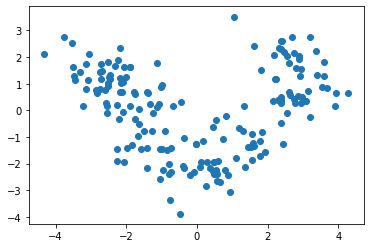

In [4]:
import matplotlib.pyplot as plt
plt.scatter(Z[:, 0], Z[:, 1])

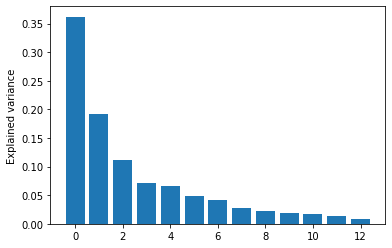

In [5]:
# plotting variance explained by each principal component
normed_eigenvals = np.array(eigen_vals) / sum(eigen_vals)
plt.figure()
plt.bar(range(len(eigen_vals)), normed_eigenvals)
plt.ylabel("Explained variance")
plt.show()

The plot shows that PC1 accounts for 35% of the variance, pc2 20% etc. 

> **Ex. 3.1.2**: Reproduce the figure from the slides that compares PCA, LDA, t-SNE and UMAP as applied to the digits dataset.
1. Do it for the digits dataset (same as in slides)
2. Do it also for the wine dataset. What problems do you observe if you don't standardize the wine dataset? Why is this not a problem with the digits data?
3. Comment on the differences you observe as well as the applicability (and necessity thereof) of different methods for different data.
>
> *Hint: You can use [this class](https://github.com/ulfaslak/ulf_pytools/blob/7f4f1eb7e2d721851c8dacb20904478b19090f2a/ulf.py#L451) for making coloring easier. It lets you create a function that takes a category as input and returns an associated color. Read the docstring for usage example.*

In [6]:
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [7]:
X_PCA = PCA(n_components=2).fit_transform(X_digits)
X_LDA = LDA(n_components=2).fit_transform(X_digits,y_digits)
X_TSNE = TSNE(n_components=2).fit_transform(X_digits)
X_UMAP = UMAP(n_components=2).fit_transform(X_digits)

/Users/smeden/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


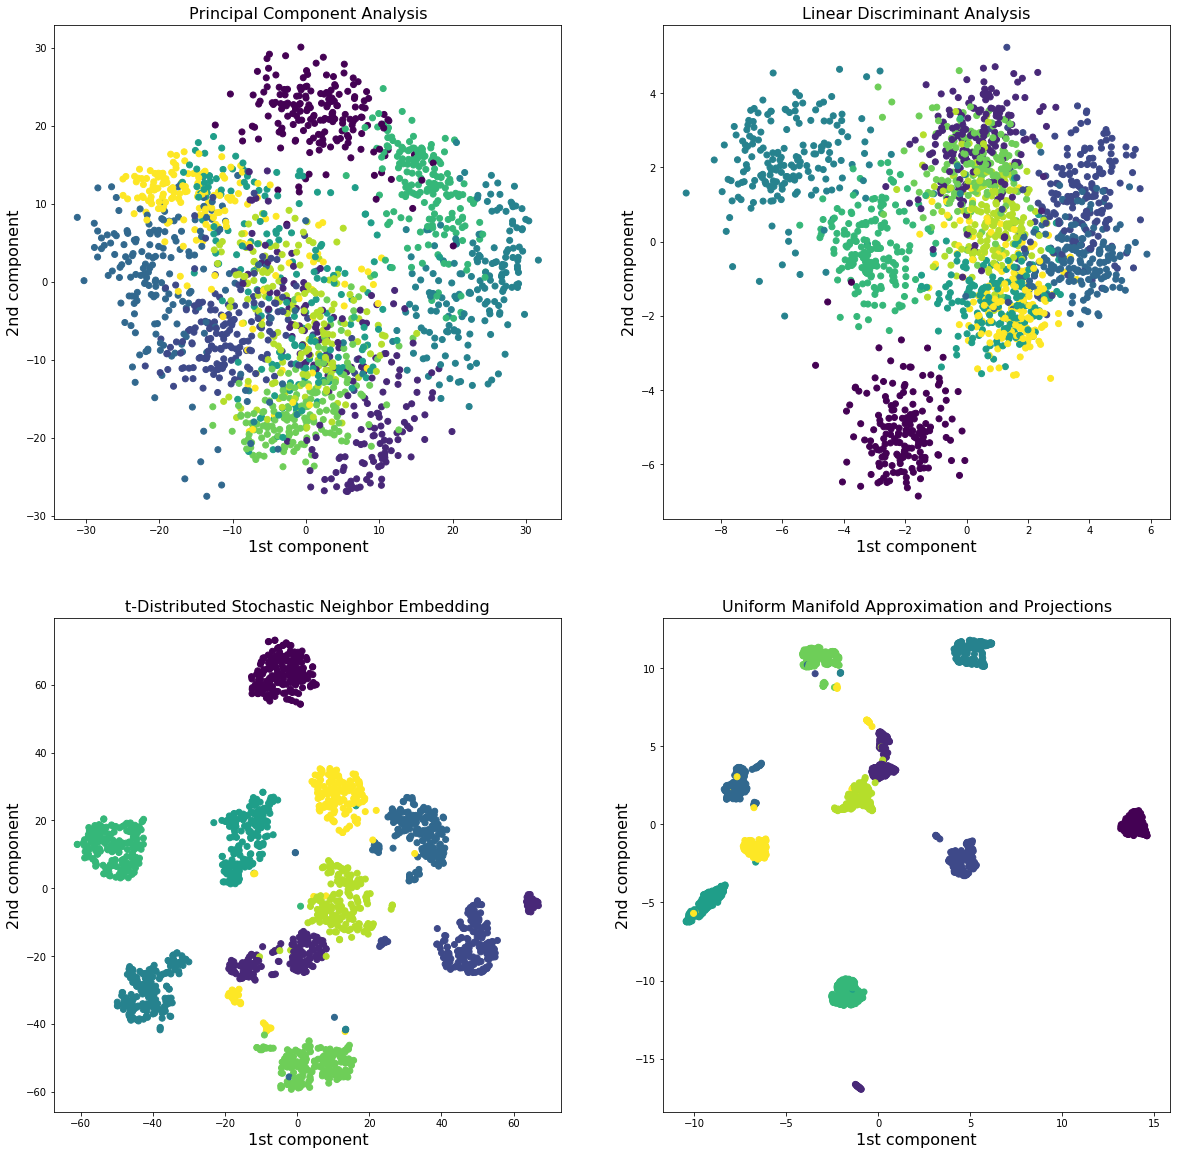

In [8]:
fig = plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=y_digits, cmap='viridis')
plt.title("Principal Component Analysis", fontsize=16)
plt.xlabel("1st component", fontsize=16)
plt.ylabel("2nd component",fontsize=16)
plt.subplot(2,2,2)
plt.scatter(X_LDA[:,0], X_LDA[:,1], c=y_digits, cmap='viridis')
plt.title("Linear Discriminant Analysis", fontsize=16)
plt.xlabel("1st component", fontsize=16)
plt.ylabel("2nd component",fontsize=16)
plt.subplot(2,2,3)
plt.scatter(X_TSNE[:,0], X_TSNE[:,1], c=y_digits, cmap='viridis')
plt.title("t-Distributed Stochastic Neighbor Embedding", fontsize=16)
plt.xlabel("1st component", fontsize=16)
plt.ylabel("2nd component",fontsize=16)
plt.subplot(2,2,4)
plt.scatter(X_UMAP[:,0], X_UMAP[:,1], c=y_digits, cmap='viridis')
plt.title("Uniform Manifold Approximation and Projections", fontsize=16)
plt.xlabel("1st component", fontsize=16)
plt.ylabel("2nd component",fontsize=16)

plt.show()

## Clustering

> **Ex. 3.2.1**: Implement K-means. I have written parts of the core code and a template for the code below. You can use it if you get stuck. Preferably, write your code as a function that takes as input the data `X`, `K` and a maximum number of iterations, and outputs the kernels, the memberships and the number of iterations it took to converge. You must fit a K-Means solutions with 3 kernels on the wine dataset projected onto the first two principal components.
1. Make a plot like the one below, that also clearly shows the position of the fitted kernels.
2. Run your code 100 times and plot the distribution of iterations until convergence.
3. Since this is an unsupervised solution, the labels you have obtained are probably different from the ones given by the `y` vector. But we still want to assess its accuracy. You could deal with this by relabeling the solution, but it's easier to use the *adjusted mutual information* as a performance metric. Use `sklearn.metrics.adjusted_mutual_info_score` to report the performance of one clustering solution.

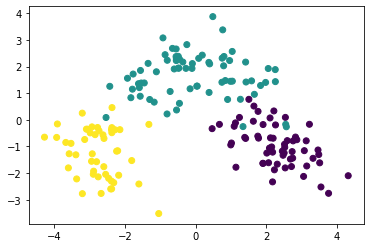

In [9]:
# fit the pca and get the two first components
X_wine_std = StandardScaler().fit_transform(X_wine)
X_wine_pca = PCA().fit_transform(X_wine_std)[:, :2]

# plot it for sanity
plt.scatter(X_wine_pca[:, 0], X_wine_pca[:, 1], c=y_wine)
plt.show()

In [10]:
# Set (1) `K` and (2) `max_iter`
def K_means(X=X_wine_pca, K=3, max_iter=100):

# Initialize (1) data structure to keep track of kernel positions (init randomly) and
# (2) data structure to keep track of members for of kernel (no members at start)
    kernels = [X[np.random.randint(X.shape[0])] for _ in range(K)]
    members = [[] for _ in range(K)]
    
# Start a for loop over a number of iterations
    for iter_ in range(max_iter):

        ## E-STEP: Assign members, by
        ## ------

        # (1) copying last iteration's membership vector,
        members_old = [m[:] for m in members[:]]
        # (2) resetting the membership vector,
        members = [[] for _ in range(K)]
        
        # (3) looping over datapoints `x` to
        for i, x in enumerate(X):
            # (4) find the nearest kernel and
            nearest = None
            distance = np.inf
            for k, x_k in enumerate(kernels):
                dist_k = sum(np.sqrt((x - x_k)**2))
                if dist_k < distance:
                    nearest = k
                    distance = dist_k
            # (5) add `x` as member of the corresponding kernel.
            members[nearest].append(i)
            
        ## STOPPING-CRITERIA: Select whether to stop by
        ## -----------------

        # (1) checking if the membership vector has changed since last iteration,
        if members == members_old:
        # (2) recording how many iterations it took to converge, and
            return kernels, members, iter_
        # (3) stop if it hasn't.


        ## M-STEP: Move kernels, by
        ## ------

        # (1) loop over kernels and
        for j, _ in enumerate(kernels):
            # (2) set their position to the mean of their members
            kernels[j] = np.mean([X[i].tolist() for i in members[j]], axis=0)
    else:
        return kernels, members, iter_
    
kernels, members, iter_ = K_means(X_wine_pca, K=3, max_iter=50)

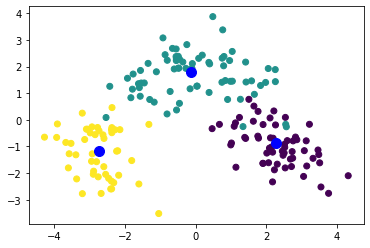

In [11]:
# plot it for sanity
plt.scatter(X_wine_pca[:, 0], X_wine_pca[:, 1], c=y_wine)
for kernel in kernels:
    plt.scatter(*kernel, color="blue", s=100)
plt.show()

> **Ex. 3.2.2:** Fit a Gaussian Mixture Model, again to the PCA transformed wine data (same as previous exercise).
1. Report the adjusted mutual information score.
2. Make a plot similar to the one above, but where points are colored by their relative association.
>
> *Hint 2: Use [my `colormixer` function](https://github.com/ulfaslak/ulf_pytools/blob/7f4f1eb7e2d721851c8dacb20904478b19090f2a/ulf.py#L388)
to color the points. Predict memberships using the `predict_proba` method, and let row vectors be input
to the `weight` in the `colormixer` function. Example:*
>
>        colormixer(['#3E1F51', '#FEE824', '#1F908B'], weights=y_predicted[0])

In [12]:
def colormixer(colors, weights=None):
    """Take array of colors in hex format and return the average color.
    
    Input
    -----
        colors : array of hex values
    
    Example
    -------
        >>> colormixer(['#3E1F51', '#FEE824', '#1F908B'])
        '#4af134'
    """
    def _to_hex(v):
        v_hex = hex(v)[2:]
        if len(v_hex) == 1:
            v_hex = "0" + v_hex
        return v_hex

    # Compute mean intensities for red, green and blue
    if weights is None:
        r = int(np.mean([int(c[1:3], 16) for c in colors]))
        g = int(np.mean([int(c[3:5], 16) for c in colors]))
        b = int(np.mean([int(c[5:7], 16) for c in colors]))
    else:
        r = int(sum([int(c[1:3], 16) * w for c, w in zip(colors, weights)]) / sum(weights))
        g = int(sum([int(c[3:5], 16) * w for c, w in zip(colors, weights)]) / sum(weights))
        b = int(sum([int(c[5:7], 16) * w for c, w in zip(colors, weights)]) / sum(weights))
    
    # Take mean of each and convert back to hex
    return '#' + _to_hex(r) + _to_hex(g) + _to_hex(b)

In [13]:
from sklearn.mixture import GaussianMixture

GMM = GaussianMixture(n_components=3)
GMM.fit(X_wine_pca)
y_hat = GMM.predict_proba(X_wine_pca)

In [14]:
colors = [
    colormixer(['#3E1F51', '#FEE824', '#1F908B'], weights=y_hat_i)
    for y_hat_i in y_hat
]

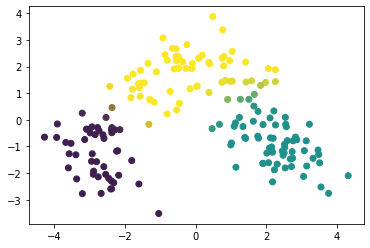

In [15]:
plt.scatter(X_wine_pca[:, 0], X_wine_pca[:, 1], c=colors)
plt.show()

> **Ex. 3.2.3:** Using the same approach as above to fit a GMM, evaluate the fit for a varying number of kernels (use `range(1, 11)`).
1. The "elbow method" compares cost function values for a varying number of kernels. It only decreases as `K`, decreases
and it is up to the human to interpret when the curve breaks, indicating what the best value of `K` is. Having fitted
a GMM object `gmm_model`, the cost function value (negative log likelihood) is obtained like `-sum(gmm_model.score_samples(X))`,
where `X` is the data you fitted the model to. Make an elbow plot and comment on it.
2. To make parameter choise easier, people often use AIC and BIC as corrections to the cost function values (they each add
different penalties to the cost function for having a large number of parameters in your model), that allows
one to take the minimum on the "elbow" curve (it's no longer an elbow plot, but you get the idea). In the same figure,
plot AIC and BIC within the range `range(1, 11)`. Comment on the result. Which one gives a better picture of what the right number of kernels is?
3. Repeat step 2, but with the full standardized wine dataset. Comment on the result. Does it still work?
4. Try with the digit data for `K` in `range(1, 21)`. Any comments?

**ANSWER 1**

In [16]:
nll = []
kernels = range(1,11)
for k in kernels:
    gmm_model = GaussianMixture(n_components=k)
    gmm_model.fit(X_wine_pca)
    nll.append(-sum(gmm_model.score_samples(X_wine_pca)))

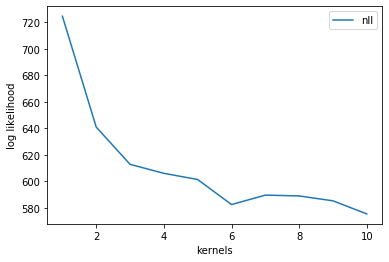

In [17]:
plt.figure()
plt.plot(kernels,nll,label="nll")
plt.ylabel("log likelihood")
plt.xlabel("kernels")
plt.legend()
plt.show()

**ANSWER 2**

In [18]:
AIC = []
BIC = []

for k in kernels:
    gmm_model = GaussianMixture(n_components=k)
    gmm_model.fit(X_wine_pca)
    AIC.append(gmm_model.aic(X_wine_pca))
    BIC.append(gmm_model.bic(X_wine_pca))

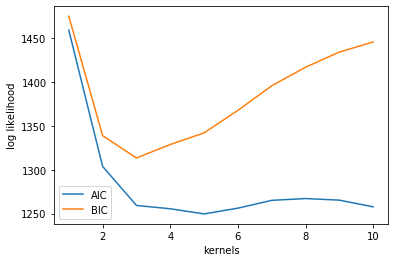

In [19]:
plt.figure()
plt.plot(kernels,AIC,label="AIC")
plt.plot(kernels,BIC,label="BIC")
plt.ylabel("log likelihood")
plt.xlabel("kernels")
plt.legend()
plt.show()

BIC shows that 3 kernels is the optimal number. 

**ANSWER 3**

In [20]:
AIC = []
BIC = []

for k in kernels:
    gmm_model = GaussianMixture(n_components=k)
    gmm_model.fit(X_wine_std)
    AIC.append(gmm_model.aic(X_wine_std))
    BIC.append(gmm_model.bic(X_wine_std))

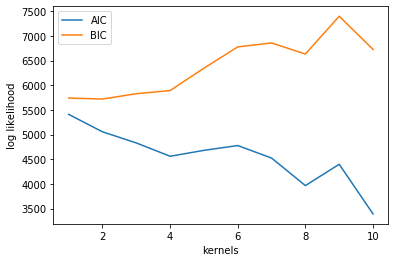

In [21]:
plt.figure()
plt.plot(kernels,AIC,label="AIC")
plt.plot(kernels,BIC,label="BIC")
plt.ylabel("log likelihood")
plt.xlabel("kernels")
plt.legend()
plt.show()

**ANSWER 4**

In [22]:
AIC = []
BIC = []

kernels = range(1,21)

for k in kernels:
    gmm_model = GaussianMixture(n_components=k)
    gmm_model.fit(X_digits)
    AIC.append(gmm_model.aic(X_digits))
    BIC.append(gmm_model.bic(X_digits))

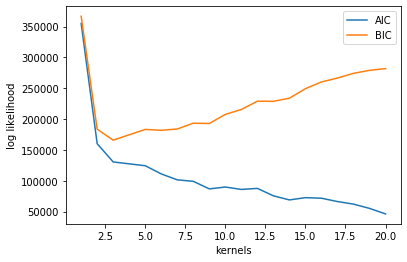

In [23]:
plt.figure()
plt.plot(kernels,AIC,label="AIC")
plt.plot(kernels,BIC,label="BIC")
plt.ylabel("log likelihood")
plt.xlabel("kernels")
plt.legend()
plt.show()

> **Ex. 3.2.4:** If your solution looks anything like mine, you would conclude that parametric clustering has
problems in high-dimensional data with many clusters. So let's try a non-parametric approach, using DBSCAN.
* Fit DBSCAN (imported from sklearn) on the digit data in its original dimensions (`X_digits`),
* then visualize the result by plotting the t-SNE transformed datapoints, colored by their recovered cluster label.
* Try different values of `eps` with DBSCAN until you feel you have a satisfying result.
* Report the adjusted mutual information between the obtained labeling and the true labeling.
* Comment on your result.

**NOTE**

*eps*: specifies how close points should be to each other to be considered a part of a cluster. It means that if the distance between two points is lower or equal to this value (eps), these points are considered neighbors. if the eps value chosen is too small, a large part of the data will not be clustered. It will be considered outliers because don’t satisfy the number of points to create a dense region. On the other hand, if the value that was chosen is too high, clusters will merge and the majority of objects will be in the same cluster. 

In [49]:
from sklearn.cluster import DBSCAN

AMI = []

for e in range(1,50):
    y_hat_DBSCAN = (DBSCAN(eps=e).fit_predict(X_digits))
    AMI.append(adjusted_mutual_info_score(y_hat_DBSCAN,y_digits))

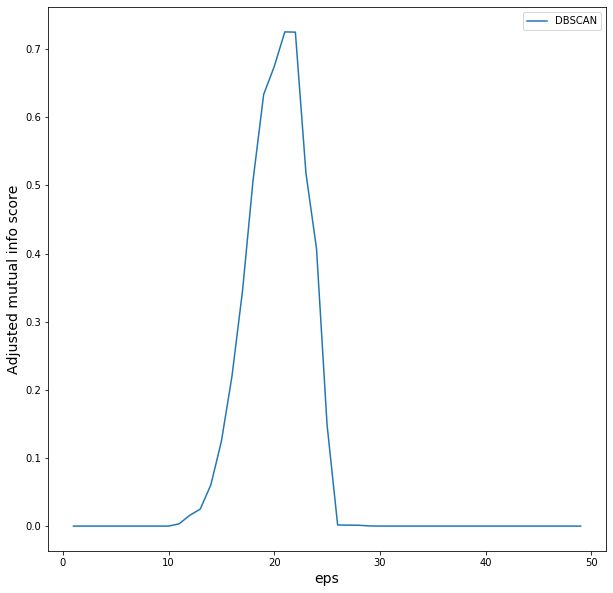

In [52]:
plt.figure(figsize=(10,10))
plt.plot(range(1,50),AMI,label="DBSCAN")
plt.ylabel("Adjusted mutual info score", fontsize=14)
plt.xlabel("eps",fontsize=14)
plt.legend()
plt.show()

Text(0, 0.5, '2nd component')

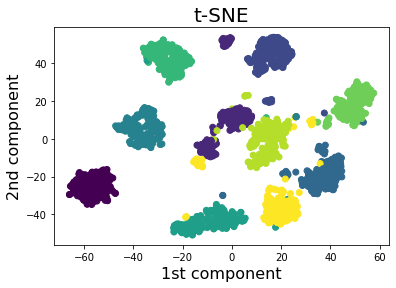

In [30]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_digits)
plt.title("t-SNE", fontsize=20)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_digits, cmap='viridis')
plt.xlabel("1st component", fontsize=16)
plt.ylabel("2nd component", fontsize=16)

> **Ex. 3.2.5:** Compare DBSCAN with agglomerative clustering. In a `for` loop over "distance threshold"
(corresponding to `eps` in DBSCAN):
* Obtain (1) DBSCAN, and agglomerative clustering solutions. For agglomerative clustering, obtain solutions for all
configurations of `linkage` (that it 'ward', 'average', 'complete', 'single').
* In total this gives you five different labelings of the datapoints in the `X_digits` dataset. For each, compute 
the adjusted mutual information (AMI) with the true labeling. Append these values to seperate arrays.
* In one figure, plot the AMI curve of each of the five methods. Label them properly and display a legend so one can compare
* Comment on the result. Which method performs the best on this dataset? How sensitive is each method to distance threshold?
>
> *Hint: A good range of distance thresholds is `range(6, 100)`.*

In [40]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score
import warnings
warnings.filterwarnings('ignore')

In [41]:
AC_ward = []
AC_complete = []
AC_average = []
AC_single = []

for i in range(6,100):
    y_hat_ward = AgglomerativeClustering(n_clusters=None,linkage="ward",distance_threshold=i).fit(X_digits).labels_
    y_hat_complete = AgglomerativeClustering(n_clusters=None,linkage="complete",distance_threshold=i).fit(X_digits).labels_
    y_hat_average = AgglomerativeClustering(n_clusters=None,linkage="average",distance_threshold=i).fit(X_digits).labels_
    y_hat_single = AgglomerativeClustering(n_clusters=None,linkage="single",distance_threshold=i).fit(X_digits).labels_
    
    AC_ward.append(adjusted_mutual_info_score(y_hat_ward,y_digits))
    AC_complete.append(adjusted_mutual_info_score(y_hat_complete,y_digits))
    AC_average.append(adjusted_mutual_info_score(y_hat_average,y_digits))
    AC_single.append(adjusted_mutual_info_score(y_hat_single,y_digits))


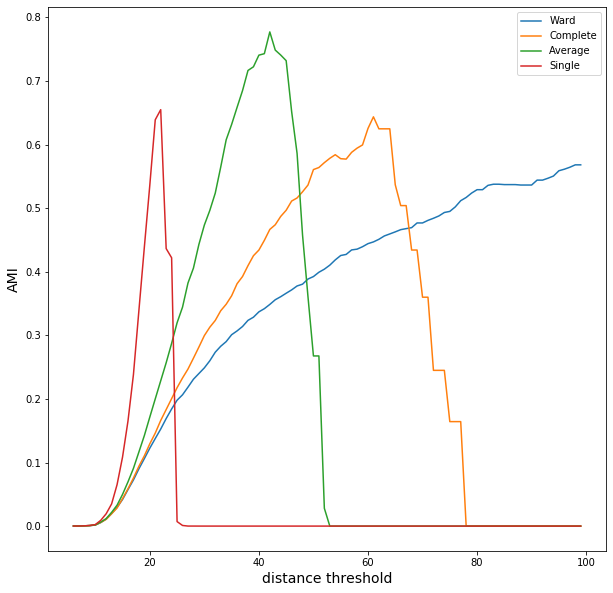

In [44]:
plt.figure(figsize=(10,10))
plt.plot(range(6,100),AC_ward,label="Ward")
plt.plot(range(6,100),AC_complete,label="Complete")
plt.plot(range(6,100),AC_average,label="Average")
plt.plot(range(6,100),AC_single,label="Single")
plt.xlabel("distance threshold", fontsize=14)
plt.ylabel("AMI", fontsize=14)
plt.legend()
plt.show()

AgglomerativeClustering with linkage "Average" has the highest AMI with a distance threshold of approximately 40. 